# Diabetes Predictor Model - Modeling

### In this notebook we will:
### 1. Apply 2-3 different modeling methods
### 2. Apply model hyperparameter tuning methods
### 3. Define the metrics I use to choose my final model
### 4. Evaluate the performance of the different models 
### 5. Identify one of the models as the best model 

##### The main objective is to develop a binary classification model to predict if an individual has Diabetes using their personal and health indicators

### Imports

In [4]:
!pip install xgboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, \
confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve, \
make_scorer, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from xgboost import XGBClassifier, DMatrix

#show plots inline
%matplotlib inline

##### Since I have a binary classification problem, I am going to use the following modeling methods...
##### 1. XGBoost (tree-based model)
##### 2. K-Nearest Neighbors (KNN) (instance-based model)
##### 3. Support Vector Machine (SVM) (margin-based model)

### Loading the Data

In [5]:
# Reading the saved CSV's
# Using .squeeze() to turn my single-column DataFrame into a Series

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()

In [7]:
# Ensuring the shapes match

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(202944, 21) (202944,)
(50736, 21) (50736,)


In [9]:
print(X_train.dtypes)

HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object


In [11]:
print(y_train.dtypes)

int64


### XGBoost Model

In [14]:
# Creating a SMOTE + XGB pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',
        eval_metric='logloss',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

In [16]:
# Applying hyperparameter tuning
param_grid = {
    'xgb__n_estimators': [100, 200, 400],
    'xgb__learning_rate': [0.01, 0.03, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 1, 5],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [1, 5, 10]
}

In [18]:
# Using RandomizedSearchCV to determine the best hyperparameters for the XGB model

rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='recall',
    cv=3,
    random_state=42,
    n_jobs=1,
    verbose=2
)


rand.fit(X_train, y_train)
best_xgb = rand.best_estimator_

print("Best Score:" + str(rand.best_score_))
print("Best Parameters: " + str(rand.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   5.9s
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   6.4s
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   6.6s
[CV] END xgb__colsample_bytree=0.6, xgb__gamma=0, xgb__learning_rate=0.03, xgb__max_depth=3, xgb__min_child_weight=3, xgb__n_estimators=200, xgb__reg_alpha=1, xgb__reg_lambda=5, xgb__subsample=1.0; total time=   5.9s
[CV] END xgb__colsample_bytree=0.6, xgb__gamma=0, xgb__learning_rate=0.

In [20]:
# Getting predictions
y_pred = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     42741
           1       0.32      0.78      0.45      7995

    accuracy                           0.70     50736
   macro avg       0.63      0.73      0.62     50736
weighted avg       0.84      0.70      0.74     50736



##### My model is maximizing on recall as not catching a diabetes diagnosis can be severe
##### Recall is good but I sacrificed precision

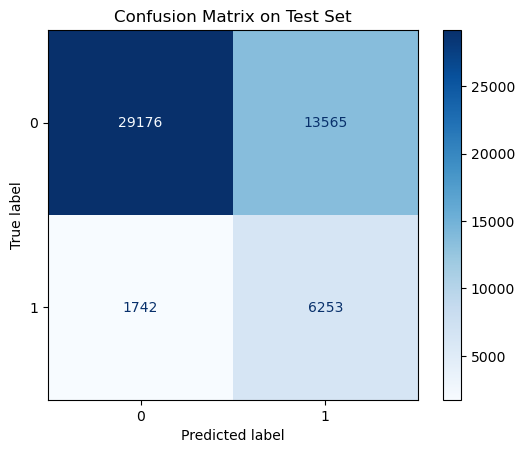

In [22]:
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

##### Based on the confusion matrix...
##### 1.) There are 29176 correct diabetes predictions
##### 2.) There are 6253 correct predictions for non-diabetes
##### 3.) There are 13565 diabetes predictions that are wrong
##### 4.) There are 1742 non-diabetes predictions that are wrong